# Experiments in reproducing the LSTM architecture for robot control using Torch.

In [2]:
import sys
sys.path.append("..")
from settings import Config

import pathlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

## Training data

Generating predictable and unpredictable training data. 

In [3]:

def generate_training_sequence(total_length, latent_size, y_size=5): 
    """
    Generates two sequences of specified length and width with some of the cells being predictable (being based on sine and cosine values etc). 
    The x_seq is going to be used for simple prediction of an evolving stream. The y_seq is going to be used to check whether a different shaped stream that is fully determined by the x_seq can be predicted. 
    """
    assert latent_size > 6
    # the x sequence - initialized with random
    x_seq = torch.rand(latent_size, total_length)
    # x_2 sin(i* pi/10)  
    x_seq[2] = torch.linspace(0, 2 * torch.pi * total_length / 10.0, steps = total_length)
    x_seq[2].sin_()

    # x_3 cos(i* pi/10)
    x_seq[3] = torch.linspace(0, 2 * torch.pi * total_length / 10.0, steps = total_length)
    x_seq[3].cos_()

    # x_4 sin(i* pi/20)
    x_seq[4] = torch.linspace(0, 2 * torch.pi * total_length / 20.0, steps = total_length)
    x_seq[4].sin_()

    # x_5 cos(i* pi/20)
    x_seq[5] = torch.linspace(0, 2 * torch.pi * total_length / 20.0, steps = total_length)
    x_seq[5].cos_()

    # initialize the x_6 with some randomness with 1 or -1
    for i in range(total_length):
        val = x_seq[6, i].item()
        x_seq[6, i] = 0
        if val < 0.1:
            x_seq[6, i] = -1
        if val > 0.9:
            x_seq[6, i] = 1

    # the y_sequence
    y_seq = torch.rand(y_size, total_length)
    # y_1 sin(i-shift)/10
    shift = -0.2 * 2 * torch.pi 
    y_seq[1] = torch.linspace(shift, shift+ 2 * torch.pi * total_length / 10.0, steps = total_length)
    y_seq[1].cos_()

    acc2 = 0
    acc5 = 0
    val4 = 0
    
    for i in range(total_length):
        #y_seq[0, i] = x_seq[0, i]
        #y_seq[1, i] = x_seq[1, i]
 
        # y_2 sum of x_2
        acc2 += x_seq[2, i]
        y_seq[2, i] = acc2

        # y_3 sum of x_5
        acc5 += x_seq[5, i]
        y_seq[3, i] = acc5
        
        # y_4 1 or -1 depending on whether the previous non-zero x_6 was 1 or -1
        if x_seq[6, i] < 0.1:
            val4 = -1
        if x_seq[6, i] > 0.1:
            val4 = 1
        y_seq[4, i] = val4

    # transpose them such that the first index gets the value at a 
    # certain timecode. 
    # FIXME: maybe this could have been initialized like this, but it is ok
    x_seq.transpose_(0, 1)
    y_seq.transpose_(0, 1)
    return x_seq, y_seq



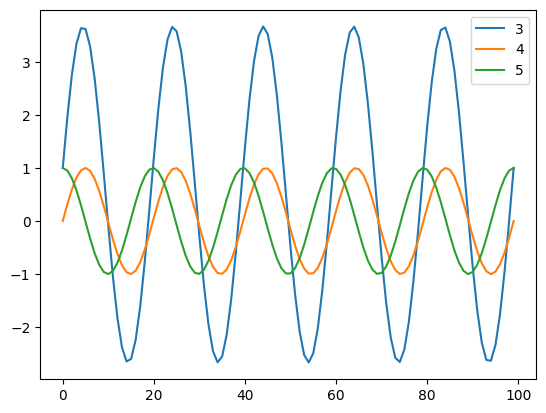

In [4]:
# Experiments in visualizing the generated training sequence
total_length = 100
# latent_size = 6
x_seq, y_seq = generate_training_sequence(total_length=100, latent_size=7)
plt.plot(y_seq[0:100,3], label= "3")
plt.plot(x_seq[0:100,4], label= "4")
plt.plot(x_seq[0:100,5], label= "5")
plt.legend()

In [5]:
def create_training_sequence_prediction(x_seq, sequence_length):
    """Create supervised training data from the single long sequence. In this data, from a string of length sequence_length we are predicting the next item."""
    # Prepare training data
    total_length = x_seq.shape[0]
    inputs = []
    targets = []
    for i in range(total_length - sequence_length):
        # Input is a subsequence of length `sequence_length`
        input_seq = x_seq[i:i + sequence_length]  # Shape: [sequence_length, latent_size]
        
        # Target is the next vector after the input sequence
        target = x_seq[i + sequence_length]       # Shape: [latent_size]
        
        # Append to lists
        inputs.append(input_seq)
        targets.append(target)

    # Convert lists to tensors for training
    inputs = torch.stack(inputs)   # Shape: [num_samples, sequence_length, latent_size]
    targets = torch.stack(targets) # Shape: [num_samples, latent_size]
    return inputs, targets

In [6]:

sequence_length = 10  # Number of vectors in input sequence
inputs, targets = create_training_sequence_prediction(x_seq, sequence_length=sequence_length)
# Verify shapes
print("Inputs shape:", inputs.shape)   # Expected: [num_samples, sequence_length, latent_size]
print("Targets shape:", targets.shape) # Expected: [num_samples, latent_size]

Inputs shape: torch.Size([90, 10, 7])
Targets shape: torch.Size([90, 7])


## LSTM model for sequence prediction
Create an LSTM model for predicting a sequence. Train it. 

In [7]:
# This is the architecture created by chatgpt
class LSTMSequencePredictor(nn.Module):
    def __init__(self, latent_size, hidden_size, num_layers):
        super(LSTMSequencePredictor, self).__init__()
        self.lstm = nn.LSTM(latent_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, latent_size)

    def forward(self, x):
        # x: [batch_size, sequence_length, latent_size]
        out, _ = self.lstm(x)  # LSTM output shape: [batch_size, sequence_length, hidden_size]
        out = self.fc(out[:, -1, :])  # Take last time step output and pass through the fully connected layer
        return out  # Predicted next vector

In [ ]:
# LSTM controller with residuals and three layers
# This code is written by Lotzi
class LSTMResidualController(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size):
        super(LSTMResidualController, self).__init__()
        self.lstm_1 = nn.LSTM(latent_size, hidden_size, num_layers=1, batch_first=True)

        self.lstm_2 = nn.LSTM(hidden_size, hidden_size, num_layers=1, batch_first=True)

        self.lstm_3 = nn.LSTM(hidden_size, hidden_size, num_layers=1, batch_first=True)

        self.fc = nn.Linear(hidden_size, latent_size)

    def forward(self, x):
        # x: [batch_size, sequence_length, latent_size]
        out_1, _ = self.lstm_1(x)
        residual = out_1
        out_2, _ = self.lstm_2(out_1)
        out_2 = out_2 + residual
        residual = out_2
        out_3, _ = self.lstm_3(out_2)
        out_3 = out_3 + residual

        # LSTM output shape: [batch_size, sequence_length, hidden_size]
        out = self.fc(out_3[:, -1, :])  # Take last time step output and pass through the fully connected layer
        return out  # Predicted next vector

In [24]:

# Model Parameters
# Original
# latent_size = 7  # Dimension of each vector in the sequence
# hidden_size = 32  # Size of hidden state in LSTM
# num_layers = 2    # Number of LSTM layers

# Original
latent_size = 7  # Dimension of each vector in the sequence
hidden_size = 3  # Size of hidden state in LSTM
num_layers = 1    # Number of LSTM layers

# Simple model: Instantiate model, loss function, and optimizer
model = LSTMSequencePredictor(latent_size=latent_size, hidden_size=hidden_size, num_layers=num_layers)

# Residual model: Instantiate model, loss function, and optimizer
# model = LSTMResidualController(latent_size=latent_size, hidden_size=hidden_size, output_size = hidden_size)

criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create the training data
total_length = 100
x_seq, y_seq = generate_training_sequence(total_length=total_length, latent_size=latent_size)
inputs, targets = create_training_sequence_prediction(x_seq, sequence_length=sequence_length)
num_sequences = inputs.shape[0]
print(num_sequences)

90


In [25]:

# Training Loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    
    # Loop over each sequence in the batch
    for i in range(num_sequences):
        # Prepare input and target
        input_seq = inputs[i]
        target = targets[i]

        # Reshape for batch compatibility
        input_seq = input_seq.unsqueeze(0)  # Shape: [1, sequence_length, latent_size]
        target = target.unsqueeze(0)        # Shape: [1, latent_size]

        # Forward pass
        output = model(input_seq)
        loss = criterion(output, target)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 2 == 0: # was 0
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")

# FIXME: save the model
filename_lstm = Config()["controller"]["lstm_model_file"]
torch.save(model.state_dict(), filename_lstm)

Epoch [2/100], Loss: 0.2967
Epoch [4/100], Loss: 0.2481
Epoch [6/100], Loss: 0.2330
Epoch [8/100], Loss: 0.2131
Epoch [10/100], Loss: 0.1862
Epoch [12/100], Loss: 0.1623
Epoch [14/100], Loss: 0.1462
Epoch [16/100], Loss: 0.1359
Epoch [18/100], Loss: 0.1288
Epoch [20/100], Loss: 0.1236
Epoch [22/100], Loss: 0.1194
Epoch [24/100], Loss: 0.1161
Epoch [26/100], Loss: 0.1134
Epoch [28/100], Loss: 0.1112
Epoch [30/100], Loss: 0.1094
Epoch [32/100], Loss: 0.1079
Epoch [34/100], Loss: 0.1066
Epoch [36/100], Loss: 0.1056
Epoch [38/100], Loss: 0.1048
Epoch [40/100], Loss: 0.1042
Epoch [42/100], Loss: 0.1037
Epoch [44/100], Loss: 0.1033
Epoch [46/100], Loss: 0.1030
Epoch [48/100], Loss: 0.1028
Epoch [50/100], Loss: 0.1027
Epoch [52/100], Loss: 0.1027
Epoch [54/100], Loss: 0.1027
Epoch [56/100], Loss: 0.1027
Epoch [58/100], Loss: 0.1027
Epoch [60/100], Loss: 0.1028
Epoch [62/100], Loss: 0.1029
Epoch [64/100], Loss: 0.1030
Epoch [66/100], Loss: 0.1031
Epoch [68/100], Loss: 0.1032
Epoch [70/100], Lo

In [9]:
load_model = True
if load_model:
    model = LSTMSequencePredictor(latent_size=latent_size, hidden_size=hidden_size, num_layers=num_layers)
    filename_lstm = Config()["controller"]["lstm_model_file"]
    model.load_state_dict(torch.load(filename_lstm))
# FIXME: load the model

C:\Users\lboloni\AppData\Local\Temp\ipykernel_59952\2346982048.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename_lstm))


## Evaluate the trained LSTM model

In [10]:
def model_step_by_step_prediction(model, sequence_length, latent_size):
    """Run a prediction where we are always predicting the next item from the previous 10 ground truth items"""
    start = 0
    result = np.zeros((sequence_length, latent_size))
    model.eval()
    with torch.no_grad():
        for i in range(0, total_length - sequence_length):
            input_seq = x_seq[start+i : start+ i + sequence_length]
            input_val = input_seq.unsqueeze(0)
            val = model(input_val)
            result = np.append(result, [val.squeeze(0).tolist()], axis=0) 
    return result

(100, 7)


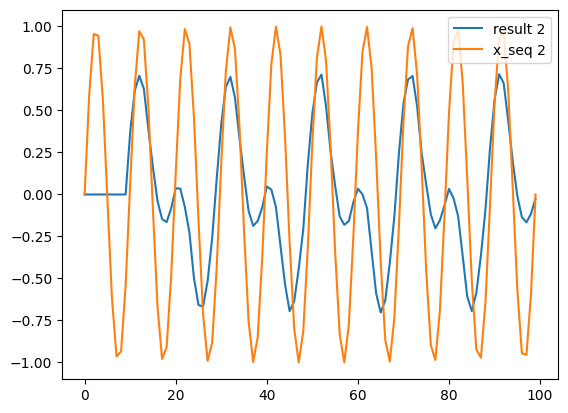

In [11]:


# Visualize the step by step prediction
result = model_step_by_step_prediction(model, sequence_length, latent_size)
print(result.shape)

channel = 2
plt.plot(result[0:100,channel], label=f"result {channel}")
plt.plot(x_seq[0:100,channel], label = f"x_seq {channel}")
plt.legend()


In [12]:
# Run autoregressive prediction (use the prediction as the next data)
def model_autoregressive_prediction(model, x_seq, sequence_length):
    """Run an autoregressive prediction where we are always predicting the next item from the previous 10 ground truth items"""
    start = 0
    result = np.zeros((sequence_length, latent_size))
    input_seq = x_seq[start : start + sequence_length]
    with torch.no_grad():
        for i in range(0, total_length - sequence_length):
            model.eval()            
            input_val = input_seq.unsqueeze(0)
            val = model(input_val)
            next_item = val.squeeze(0).tolist()
            result = np.append(result, [val.squeeze(0).tolist()], axis=0) 
            input_seq = input_seq[1: sequence_length]
            input_seq= torch.cat((input_seq, val))
    #print(result)
    return np.array(result)

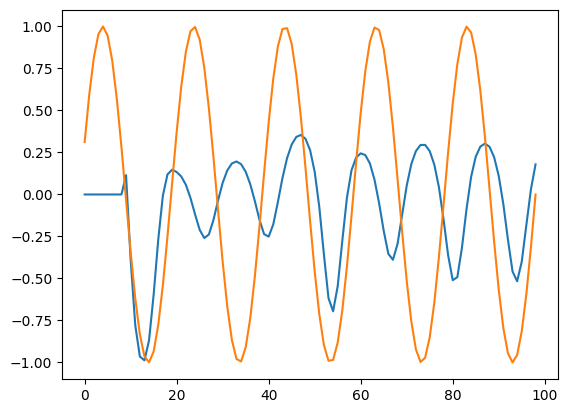

In [13]:
# Visualize the autoregressive prediction
# Calculate the error of the autoregressive prediction
# Visualize the step by step prediction
result = model_autoregressive_prediction(model, x_seq, sequence_length)
channel = 4
plt.plot(result[1:100,channel])
plt.plot(x_seq[1:100,channel])

## Training with an output which is not prediction

Training an LSTM with an output that is not a prediction of a string, but has a different dimensionality. 

In [14]:
def create_training_sequence_xy(x_seq, y_seq, sequence_length):
    """Create supervised training data from two sequences. In this data, from a string of length sequence_length we are predicting the next item in the other sequence"""
    # Prepare training data
    total_length = x_seq.shape[0]
    inputs = []
    targets = []
    for i in range(total_length - sequence_length):
        # Input is a subsequence of length `sequence_length`
        input_seq = x_seq[i:i + sequence_length]  
        # Shape: [sequence_length, latent_size]
        
        # Target is the next vector after the input sequence
        target = y_seq[i + sequence_length]       
        # Shape: [output_size]
        
        # Append to lists
        inputs.append(input_seq)
        targets.append(target)

    # Convert lists to tensors for training
    inputs = torch.stack(inputs)   # Shape: [num_samples, sequence_length, latent_size]
    targets = torch.stack(targets) # Shape: [num_samples, latent_size]
    return inputs, targets

In [15]:
# This is the architecture created by chatgpt
class LSTMXYPredictor(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size, num_layers):
        super(LSTMXYPredictor, self).__init__()
        self.lstm = nn.LSTM(latent_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: [batch_size, sequence_length, latent_size]
        out, _ = self.lstm(x)  # LSTM output shape: [batch_size, sequence_length, hidden_size]
        out = self.fc(out[:, -1, :])  # Take last time step output and pass through the fully connected layer
        return out  # Predicted next vector

In [16]:
# Model Parameters
# Original
latent_size = 7  # Dimension of each vector in the sequence
hidden_size = 32  # Size of hidden state in LSTM
num_layers = 2    # Number of LSTM layers

# Modified
# latent_size = 7  # Dimension of each vector in the sequence
# hidden_size = 3  # Size of hidden state in LSTM
# num_layers = 1    # Number of LSTM layers
output_size = 5

# Instantiate model, loss function, and optimizer
model = LSTMXYPredictor(latent_size=latent_size, hidden_size=hidden_size, output_size = output_size, num_layers=num_layers)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create the training data
total_length = 100
x_seq, y_seq = generate_training_sequence(total_length=total_length, latent_size=latent_size, y_size=output_size)
inputs, targets = create_training_sequence_xy(x_seq, y_seq, sequence_length=sequence_length)
num_sequences = inputs.shape[0]
print(inputs.shape)
print(targets.shape)

torch.Size([90, 10, 7])
torch.Size([90, 5])


In [17]:
# Training Loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    
    # Loop over each sequence in the batch
    for i in range(num_sequences):
        # Prepare input and target
        input_seq = inputs[i]
        target = targets[i]

        # Reshape for batch compatibility
        input_seq = input_seq.unsqueeze(0)  # Shape: [1, sequence_length, latent_size]
        target = target.unsqueeze(0)        # Shape: [1, latent_size]

        # Forward pass
        output = model(input_seq)
        loss = criterion(output, target)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 2 == 0: # was 0
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")

# FIXME: save the model
filename_lstm = Config()["controller"]["lstm_model_file"]
torch.save(model.state_dict(), filename_lstm+".2")

Epoch [2/100], Loss: 0.3277
Epoch [4/100], Loss: 0.1153
Epoch [6/100], Loss: 0.0843
Epoch [8/100], Loss: 0.0700
Epoch [10/100], Loss: 0.0140
Epoch [12/100], Loss: 0.0313
Epoch [14/100], Loss: 0.0330
Epoch [16/100], Loss: 0.0088
Epoch [18/100], Loss: 0.0247
Epoch [20/100], Loss: 0.0090
Epoch [22/100], Loss: 0.0360
Epoch [24/100], Loss: 0.0360
Epoch [26/100], Loss: 0.0159
Epoch [28/100], Loss: 0.0128
Epoch [30/100], Loss: 0.0264
Epoch [32/100], Loss: 0.0221
Epoch [34/100], Loss: 0.0209
Epoch [36/100], Loss: 0.0762
Epoch [38/100], Loss: 0.0134
Epoch [40/100], Loss: 0.0123
Epoch [42/100], Loss: 0.0179
Epoch [44/100], Loss: 0.0180
Epoch [46/100], Loss: 0.0122
Epoch [48/100], Loss: 0.0096
Epoch [50/100], Loss: 0.0105
Epoch [52/100], Loss: 0.0346
Epoch [54/100], Loss: 0.0211
Epoch [56/100], Loss: 0.0157
Epoch [58/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0189
Epoch [62/100], Loss: 0.0090
Epoch [64/100], Loss: 0.0134
Epoch [66/100], Loss: 0.0144
Epoch [68/100], Loss: 0.0127
Epoch [70/100], Lo

In [18]:
# FIXME: not implemented yet

def model_xy_prediction(model, x_seq, sequence_length, latent_size, output_size):
    """Model the XY prediction"""
    start = 0
    result = np.zeros((sequence_length, output_size))
    model.eval()
    with torch.no_grad():
        for i in range(0, total_length - sequence_length):
            input_seq = x_seq[start+i : start+ i + sequence_length]
            input_val = input_seq.unsqueeze(0)
            val = model(input_val)
            result = np.append(result, [val.squeeze(0).tolist()], axis=0) 
    return result

(100, 5)


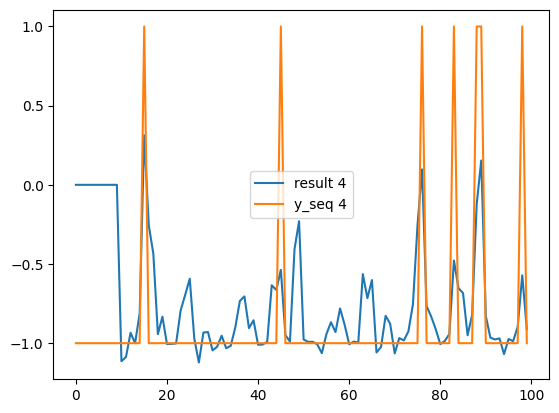

In [22]:
# Visualize the step by step prediction
result = model_xy_prediction(model, x_seq, sequence_length, latent_size, output_size)
print(result.shape)

channel = 4
plt.plot(result[0:100,channel], label=f"result {channel}")
plt.plot(y_seq[0:100,channel], label = f"y_seq {channel}")
plt.legend()
